In [1]:
import pandas as pd


import numpy as np
import pandas as pd

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import preprocess_data 

reload(preprocess_data)

%matplotlib inline

In [2]:
inpatients_with_readm = pd.read_csv('/home/daisy/FDA_Dataset/inpatients_with_readm.csv').iloc[:,1:]
demographics_event= pd.read_csv('/home/bhatti/dataset/VCHAMPS/demographics_event_train.csv').iloc[:,1:]

In [14]:
# demographics_event = inpatients_with_readm.merge(demographics_event_train, how = 'left', on = 'Internalpatientid')
# demographics_event.head()

In [3]:
demographics_event['Marital status'].value_counts()

Married                     73020
Divorced                    26856
Widowed                     19378
Never married                9352
Separated                    3708
Unknown                       534
Not specified (no value)      286
Single                        118
Name: Marital status, dtype: int64

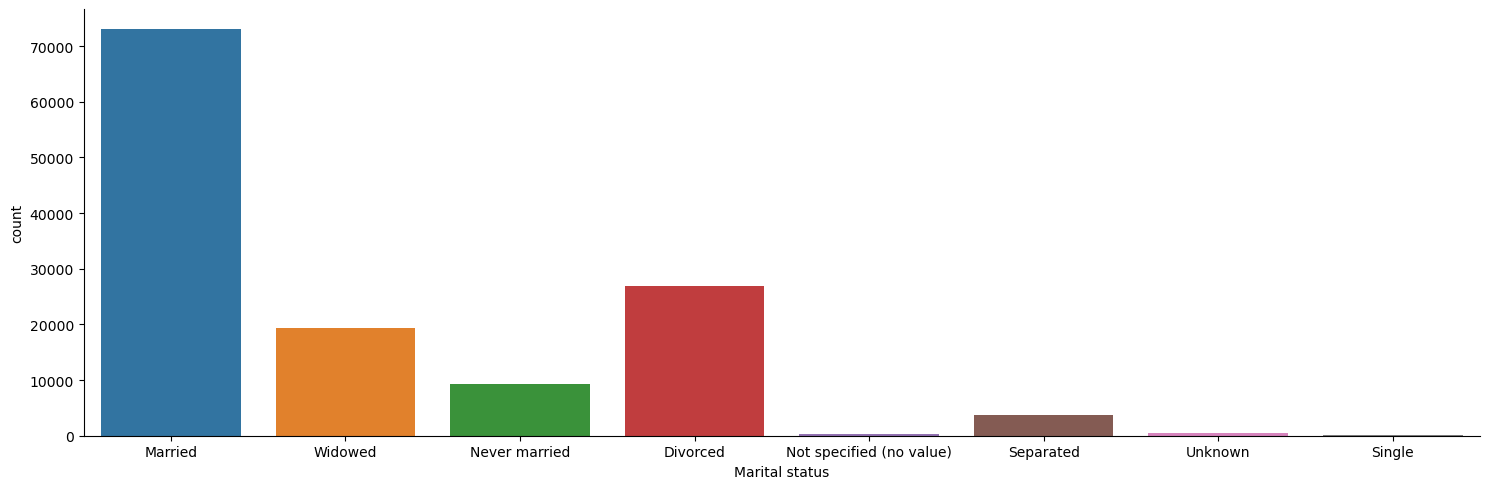

In [4]:
sns.catplot(data=demographics_event, x='Marital status', kind="count", aspect=3)

In [5]:
demographics_event['Ruca category'].value_counts()

Urban            84092
Rural            46614
Highly rural      2034
Not specified      512
Name: Ruca category, dtype: int64

In [7]:
demographics_event['Event date'] = demographics_event['Event date'].apply(preprocess_data.preprocess_time_string)

In [20]:
min(demographics_event['Event date']) # There is no invalid data

Timestamp('1995-12-01 16:26:28')

In [8]:
demographics_event['Marital status'].value_counts()

Married                     73020
Divorced                    26856
Widowed                     19378
Never married                9352
Separated                    3708
Unknown                       534
Not specified (no value)      286
Single                        118
Name: Marital status, dtype: int64

In [22]:
demographics_event['Ruca category'].value_counts()

Urban            84092
Rural            46614
Highly rural      2034
Not specified      512
Name: Ruca category, dtype: int64

## Encoding categorical data
For Marital status:
- Married -> Not single - 0
- Never married, Separated, Single, Divorced, Widowed -> Single - 1
- Not specified (no value) -> imputate

For Ruca category:
- Urban -> 0
- Rural -> 1
- Highly rural -> 2
- Not specified -> Imputate

In [9]:
marital_status = {'Married': 0, 'Divorced': 1, 'Never married': 1, 'Separated': 1, 'Single': 1, 'Unknown': float('nan'), 'Widowed': 1, 'Not specified (no value)': float('nan')}
ruca_category = {'Urban': 0,  'Rural': 1, 'Highly rural': 2, 'Not specified': float('nan')}

In [10]:
demographics_event['Marital status encoded'] = preprocess_data.preprocess_substitute_categories(marital_status, 
                                                                               demographics_event['Marital status'])

In [11]:
demographics_event['Ruca category encoded'] = preprocess_data.preprocess_substitute_categories(ruca_category, 
                                                                               demographics_event['Ruca category'])

In [12]:
pd.isnull(demographics_event).sum()

Internalpatientid           0
Age at update               0
Event date                  0
Marital status              0
Ruca category               0
Marital status encoded    820
Ruca category encoded     512
dtype: int64

In [39]:
demographics_event

,Internalpatientid,Age at update,Event date,Marital status,Ruca category,Marital status encoded,Ruca category encoded
0,100028,78.990830,2020-08-24 03:33:32,Married,Urban,0.0,0.0
1,100032,91.357622,2008-02-07 05:03:27,Married,Rural,0.0,1.0
2,100046,72.961415,2003-09-14 09:32:12,Married,Urban,0.0,0.0
3,100071,75.221222,2019-04-25 08:33:42,Widowed,Urban,1.0,0.0
4,100091,80.955929,2022-02-09 09:24:20,Never married,Urban,1.0,0.0
...,...,...,...,...,...,...,...
133247,99898,92.376313,2014-05-12 13:01:07,Married,Urban,0.0,0.0
133248,9995,79.974938,2011-07-08 20:09:29,Married,Rural,0.0,1.0
133249,99950,77.154395,2005-12-14 22:21:25,Married,Urban,0.0,0.0
133250,9998,62.324623,2011-02-23 15:35:32,Divorced,Urban,1.0,0.0


In [38]:
len(demographics_event['Internalpatientid'].unique()) # All columns are unique 

133252

# Imputing RUCA based on state

In [14]:
outpatients_location = pd.read_csv('/home/vivi/FDA_datasets/outpaitent_state.csv').iloc[:,1:]
demographics_event_location = demographics_event.merge(outpatients_location, how = 'left', on = 'Internalpatientid')

In [22]:
demographics_event_location = demographics_event_location.dropna(subset=['State']) # 

In [20]:
demographics_event_location

False    133248
True          4
Name: State, dtype: int64

In [29]:
state_ruca = demographics_event_location.groupby('State')['Ruca category encoded'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [40]:
for index, row in demographics_event_location.iterrows():
    if pd.isna(row['Ruca category encoded']):
        demographics_event_location.at[index, 'Ruca category encoded'] = state_ruca[state_ruca['State'] == row['State']]['Ruca category encoded']

In [41]:
pd.isnull(demographics_event_location).sum()

Internalpatientid           0
Age at update               0
Event date                  0
Marital status              0
Ruca category               0
Marital status encoded    820
Ruca category encoded       0
State                       0
dtype: int64

In [ ]:
demographics_event_location.to_csv('/home/vivi/FDA_datasets/demographics_event_preprocessed.csv')